# Using PyTorch Elastic Distributed Training in Watson Machine Learning Accelerator Notebook
In this sample, you will learn how to accelerate your PyTorch training using Elastic Distributed Training in Watson Machine Learning Accelerator Notebook. The kernel will start with GPU library imported but no GPU resource requested. GPU allocation to the current kernel only happens when you explicitly call Elastic Distributed Training train api in Notebook with requested maximum number, and 1 to the maximum number of GPUs will be allocated dynamically during the train execution. Here we use the MNIST dataset, a series of images of numbers, and train the model to better recognize hand written numbers.

## Environment variables
The following environment variables can be used in the Notebook. These variables specify the data source, the training directory, and directory for the trained model.

In [1]:
import os

DATA_DIR = os.getenv("DATA_DIR", "/gpfs/mydatafs")
print("DATA_DIR: " + DATA_DIR)

DATA_DIR: /gpfs/mydatafs


## Define the sample model
The following section defines the model. 

In [2]:
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from pyedt.fabric_model import FabricModel

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p =0.25, training=self.training)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.softmax(self.fc2(x), dim=1)
        return x

model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.95)

2023-10-31 04:53:01,822 224 INFO __init__.<module> - Using pytorch backend.


If you want to use 'tensorflow' or 'keras', restart kernel and export FABRIC_BACKEND before importing fabric_model modules.


## Define the dataset
The following section, defines and loads the dataset.

In [3]:
# If you set download=True the MNIST dataset is automatically downloaded and used by the Notebook. 
# If you want to use a different dataset or have previously downloaded a dataset, 
# set download=False and specify the directory that contains the dataset. 
dataset_dir = DATA_DIR + '/MNIST'
#datasets.MNIST(dataset_dir, download=True)                         

def getDatasets():
    return (datasets.MNIST(dataset_dir, train=True, download=True, transform=transforms.Compose([
                           transforms.ToTensor()
                       ])),
            datasets.MNIST(dataset_dir, train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
            )

## Start training the model 
Submit the model for training. This can take several minutes.

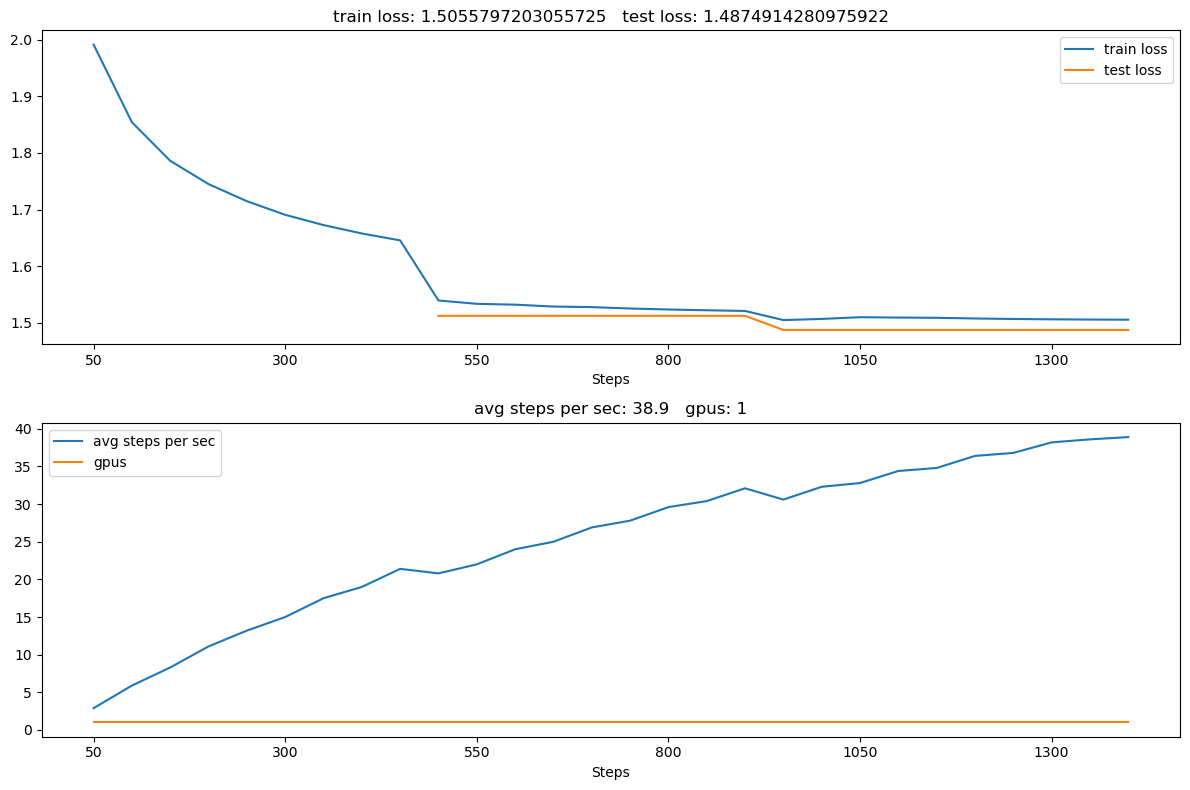

Job wmla-bjyuanxz-notebook-1698727996373 finishes with state FINISHED.
driver service subprocess 261 stopped


In [4]:
# The number of epochs to run.
NUM_EPOCHS=3
# Batch size for each iteration.
NUM_BATCH_SIZE_PER_DEVICE=128
# Maximum number of GPUs to be requested. 
# If the maximum number of GPUs is set to 6, the number of GPUs that are 
# allocated dynamically during training execution is between 1 and 6 GPUs.
MAX_NUM_WORKERS=1

edt_m = FabricModel(model, getDatasets, F.cross_entropy, optimizer)

edt_m.train(NUM_EPOCHS, NUM_BATCH_SIZE_PER_DEVICE, MAX_NUM_WORKERS)

## View the training result
After training is completed, view the saved trained model.

In [5]:
edt_m.download()

Save model:  /tmp/wmla-zxy-notebook-1681871594888.zip


Use `out_dir` argument to download to a customized directory.

In [6]:
out_dir = '/tmp/out'
edt_m.download(out_dir=out_dir)

Save model:  /tmp/out/wmla-zxy-notebook-1681871594888.zip
